# Titanic Top 4% with ensemble  modeling

## Introduction

세 가지 메인 파트들로 구성
* Feature analysis
* Feature engineering
* Modeling

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter # 해당 value의 빈도를 세기 위해

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## Load and check data
### Load data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

### Outlier detection

In [9]:
def detect_outliers(df, n, features):
    """
    Tukey 방법에 따라 아웃라이어 목록을 가져오는 함수
    """
    outlier_indices = []
    
    #변수 별
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        # 아웃라이어 인덱스
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # 추가
        outlier_indices.extend(outlier_list_col)
    
    # n이상보다 더 많은 아웃라이어를 포함한 관측치들을 선택
    outlier_indices = Counter(outlier_indices) #딕셔너리형, 변수 별로 해당 인덱스가 몇 개씩 있었는지 확인
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

> append VS extend
    > + append: x 자체를 원소로 넣음
    > + extend: 리스트 끝에 iterable의 각 항목을 넣음
    > + 참고:  https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221541104629&categoryNo=50&proxyReferer=


In [10]:
train.loc[Outlier_to_drop] # fare가 너무 높은 등 아웃라이어들이다

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [11]:
#드롭
train = train.drop(Outlier_to_drop, axis = 0).reset_index(drop=True)

### joining train and test set

In [12]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

### check for null and missing Values

In [13]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [14]:
# info
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [17]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis
### Numerical values

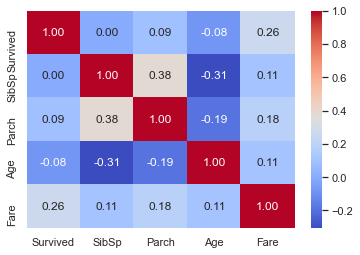

In [18]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Fare 변수만 survival 확률에 유의미하게 연관이 있는 것 같음

**SibSp**

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


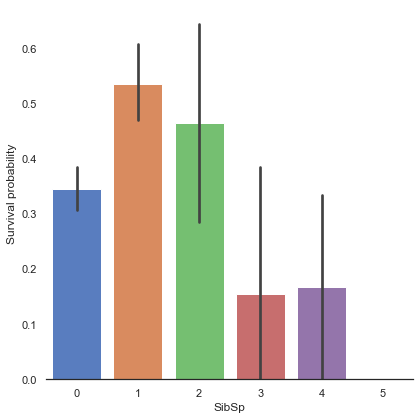

In [20]:
# SibSp vs Survived
g = sns.factorplot(x='SibSp', y='Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival probability')

형제자매가 많은 승객(3,4,5)은 생존 확률이 낮음 -> 해당 부분 범주화

**Parch**

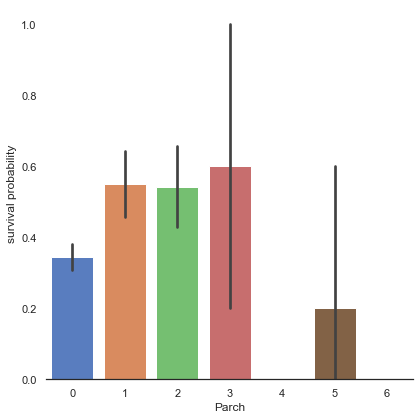

In [21]:
# Parch vs Survived

g = sns.factorplot(x='Parch', y = 'Survived', data = train, kind='bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

소규모 가족이 생존할 확률이 더 높음. 부모/자녀가 3명인 승객은 표준편차 주의

**Age**

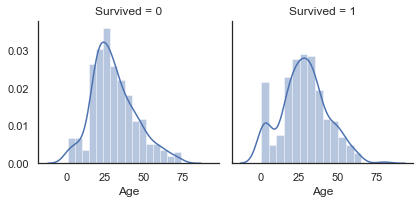

In [22]:
# Age vs Surcicied
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

* 연령 분포는 꼬리가 긴 분포, 가우시안 분포인 것 같음 
* 두 집단의 연령 분포가 동일하지 않음, 살아남은 젊은 승객에 해당하는 피크가 있고 60-80세 사이의 승객들이 덜 살아남았음
* 따라서, 연령과 생존이 관련이 없더라도 생존가능성이 있는 승객의 연령 범주가 있음을 알 수 있음
* 아주 어린애들이 생존할 확률이 더 높음

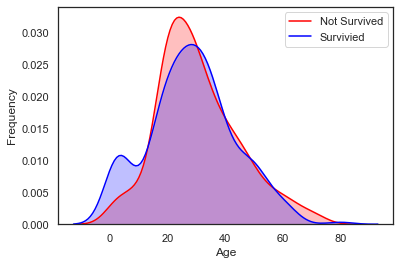

In [25]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color = 'Red',shade = True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax = g, color = 'Blue',shade = True)
g.set_xlabel("Age")
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survivied'])

생존자들 중에 아주 어린 아이들의 피크가 있음을 볼 수 있당

**Fare**

In [26]:
dataset['Fare'].isnull().sum()

1

In [28]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

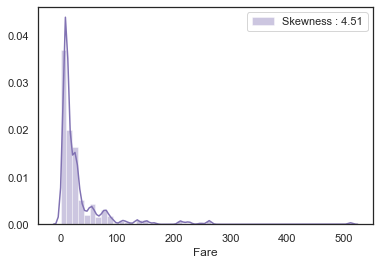

In [29]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset["Fare"].skew()))
g = g.legend(loc = 'best')

왜곡을 줄이기 위해 로그함수로 변환
-> 크기가 조정될 떄 모델에서 큰 값이 지나치게 높아질 수 있음

In [31]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

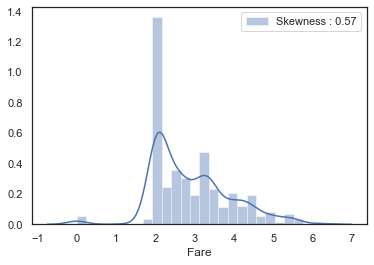

In [32]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best') # 확실히 왜곡이 줄어듦

### Categorical values
**Sex**

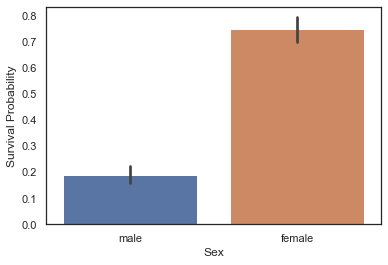

In [33]:
g = sns.barplot(x= 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [34]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


여자의 생존률이 압도적으로 높음

**Pclass**

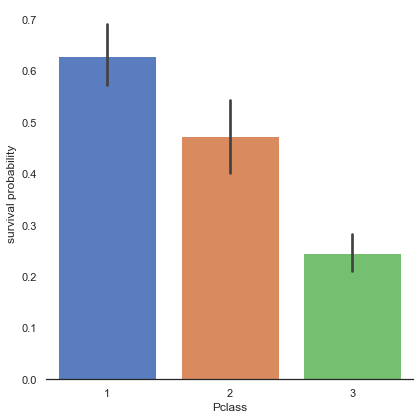

In [36]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

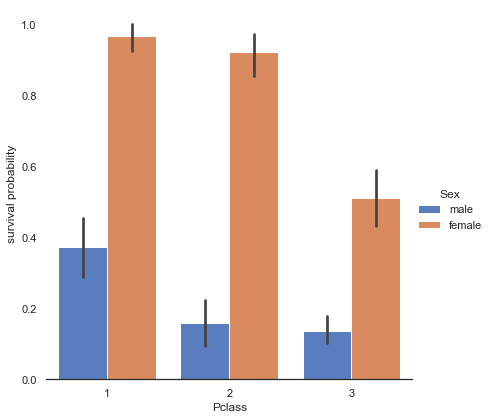

In [37]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

3등급의 생존률이 더 낮음, 1등급은 높음. 남성 여성 승객 모두 비슷한 추세 

**Embarked**

In [38]:
dataset['Embarked'].isnull().sum()

2

In [39]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

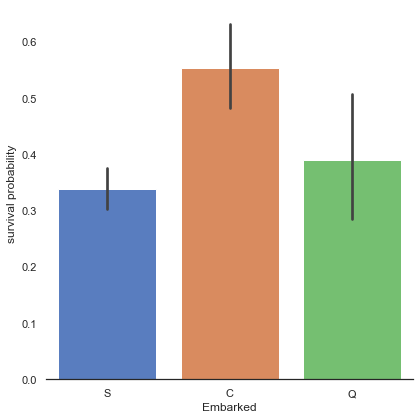

In [41]:
g = sns.factorplot(x='Embarked', y='Survived', data = train, size=6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

C에서 탄 사람이 살 확률이 더 높음. 


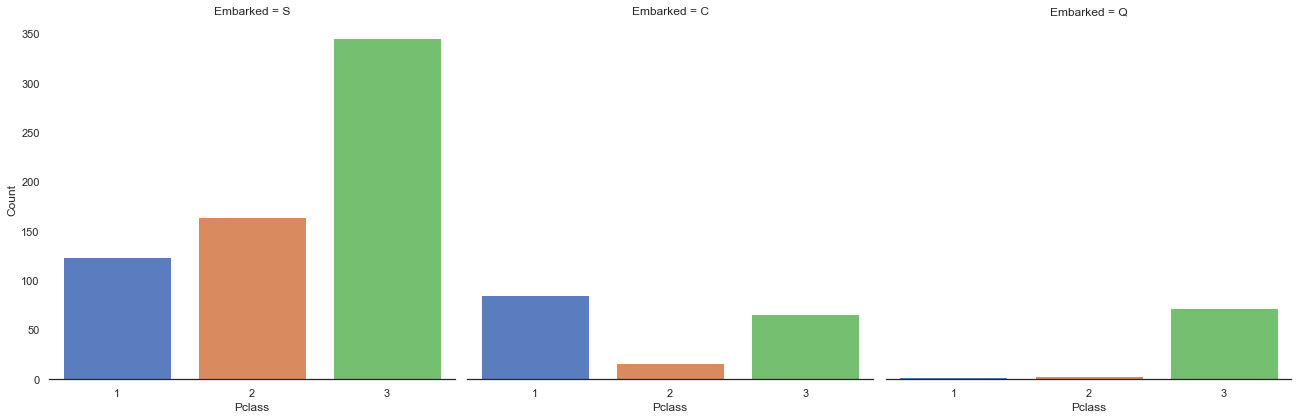

In [42]:
# pclass와의 연관성 확인
g = sns.factorplot("Pclass", col ="Embarked", data = train, size=6, kind='count', palette='muted')
g.despine(left=True)
g =g.set_ylabels("Count")

3등석은 S와 Q에서 오는 승객이 가장 빈번하고, C승객은 대부분 생존률이 가장 높은 1등석이다.

## Filling missing Values
### Age

누락된 값 256개 존재. 연령 특성을 유지하면서 결측값을 채우는 것이 좋음. 특정 집단의 생존률이 더 높기 떄문.

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

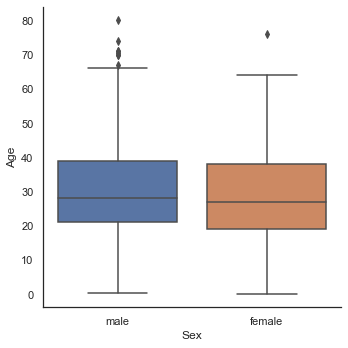

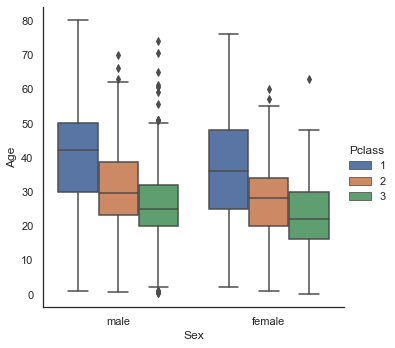

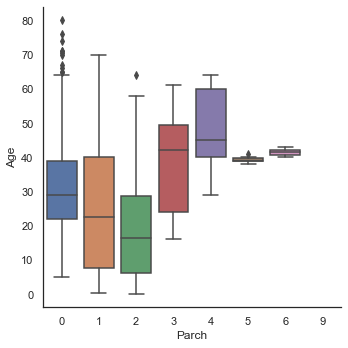

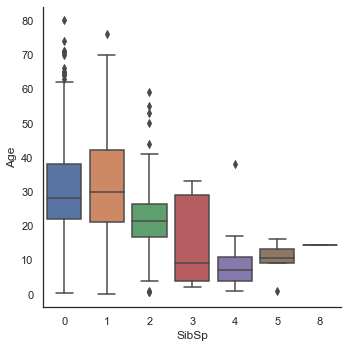

In [43]:
# Age vs Sex, Parch , Pclass and SibSP -> 변수 간 기능 확인
g = sns.factorplot(y="Age", x="Sex", data = dataset,kind="box")
g = sns.factorplot(y="Age", x="Sex", hue ="Pclass", data = dataset,kind="box")
g = sns.factorplot(y="Age", x="Parch", data = dataset,kind="box")
g = sns.factorplot(y="Age", x="SibSp", data = dataset,kind="box")

* 연령 분포는 남성과 여성이 비슷해 보이므로 성별은 연령을 예측하는데 도움이 되지 않음
* 1등석 승객은 3,2 등석 승객보다 나이가 많음
* 부모/자녀가 많을수록 나이가 많고 동생/배우자가 많을 수록 젋음

In [45]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

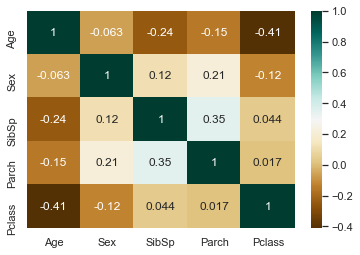

In [46]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp','Parch','Pclass']].corr(), cmap="BrBG", annot=True)

연령 결측값을 채우기 위해 SibSp, Parch, Pclass 사용하기로 결정

In [47]:
# 연령 결측값 채우기

# Pclass, Parch, SibSp와 비슷한 행의 중앙값으로 채우기
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset["Age"][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


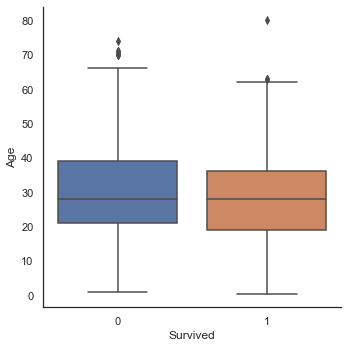

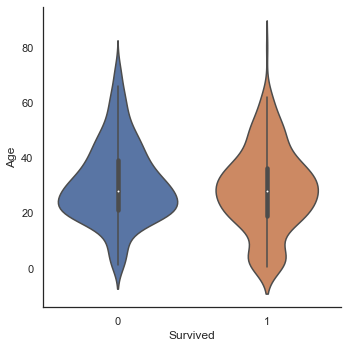

In [48]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

## Feature enginerring
### Name/Title

In [49]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [51]:
# get title from name
dataset_title = [i.split(',')[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

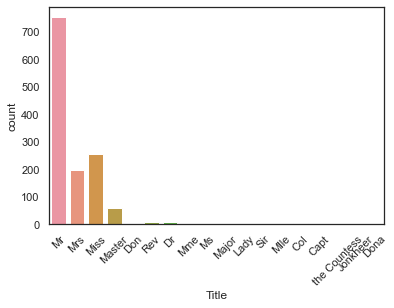

In [52]:
g = sns.countplot(x='Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45) # 선 모양 다루는 함수

In [53]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt','Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({"Master": 0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset["Title"].astype(int)

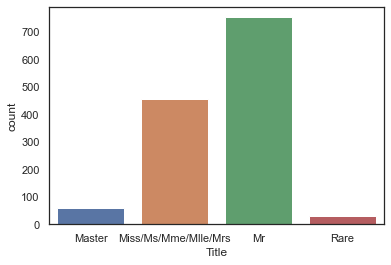

In [54]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


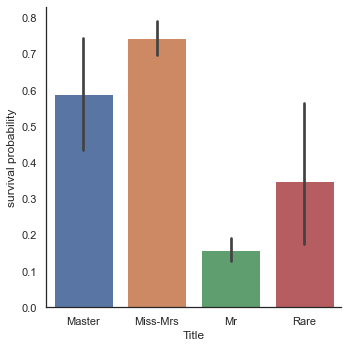

In [55]:
g = sns.factorplot(x="Title",y= "Survived",data = dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [56]:
#drop name variable
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

### Family size
Fize(가족크기) 변수를 만들기로 함. 가족이 많으면 대피하는데에 찾아다니느라 더 어려움이 있을 것이라 가정

In [57]:
dataset['Fsize']= dataset["SibSp"] + dataset['Parch'] +1 #본인까지

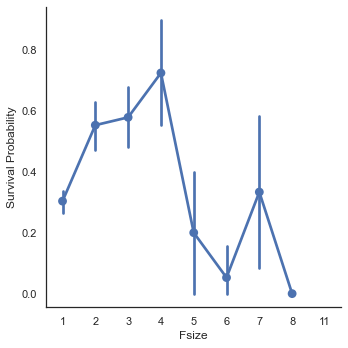

In [58]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

생존률이 large families에서 확 낮아지는 것으로 보아 중요한 역할을 할 것 같음

In [59]:
# 범주화
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<= s <=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


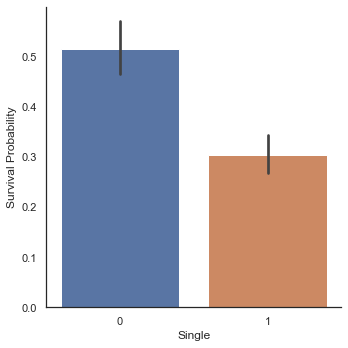

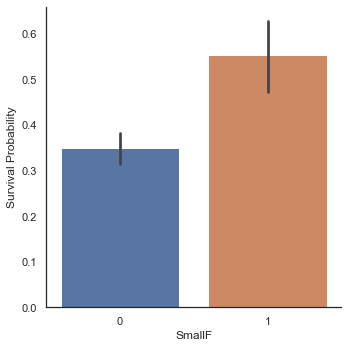

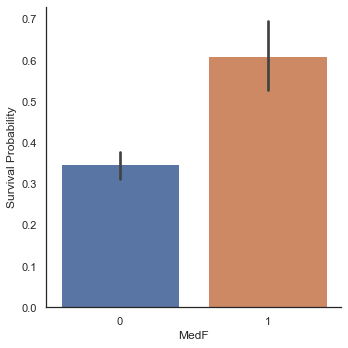

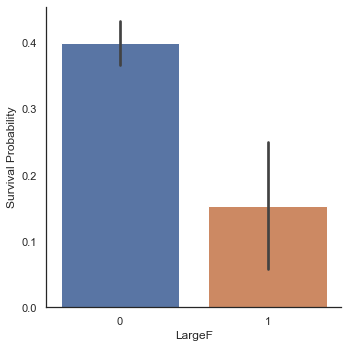

In [60]:
g = sns.factorplot(x = "Single", y = "Survived", data = dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x = "SmallF", y="Survived", data = dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x ="MedF", y="Survived", data = dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

In [61]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [62]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### Cabin

In [63]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [64]:
dataset['Cabin'].describe() # 이런 서머리는 처음, 왜 노트북과 값이 다르지 ?카운트와 유니크 차이

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [65]:
dataset['Cabin'].isnull().sum()

1007

In [67]:
dataset['Cabin'].value_counts().sum()

292

In [68]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [69]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

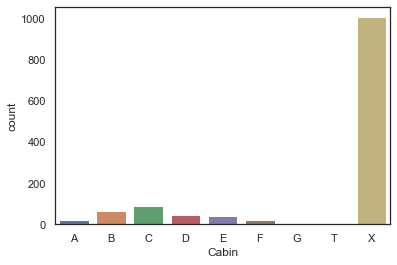

In [70]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

C:\Users\dldud\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


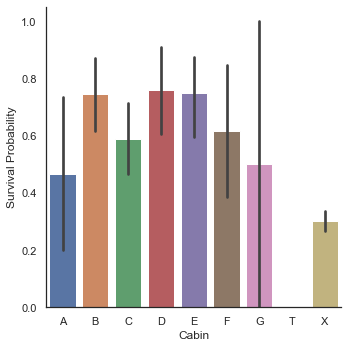

In [71]:
g = sns.factorplot(y="Survived" , x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

A,B 등 객실이 있는 승객수가 없는 승객수에 비해 현저히 적기에 중요한 표준편차를 가짐. 다른 책상의 생존확률을 구분할 수 없음. 

그러나 일반적으로 객실이 있는 승객이 없는 승객보다는 생존률이 높다는 것을 알 수 있음

In [72]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

### Ticket

In [73]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [74]:
# 접두사만 남기기
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace("/",'').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [75]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [78]:
dataset

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,...,0,0,0,0,1,0,0,0,0,0
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,0,25.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,0
1295,1306,NaN,1,1,39.0,0,0,4.690430,1,1,...,0,0,0,0,0,0,0,0,0,0
1296,1307,NaN,3,0,38.5,0,0,1.981001,1,1,...,0,1,0,0,0,0,0,0,0,0
1297,1308,NaN,3,0,25.0,0,0,2.085672,1,1,...,0,0,0,0,0,0,0,0,0,1


In [79]:
dataset['Pclass'] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns= ['Pclass'], prefix='Pc')

In [80]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [81]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling

In [82]:
# 데이터 셋 분리

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace =True)

C:\Users\dldud\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [84]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis=1)

C:\Users\dldud\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### SImple modeling
#### Cross validate models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [85]:
kfold = StratifiedKFold(n_splits=10)

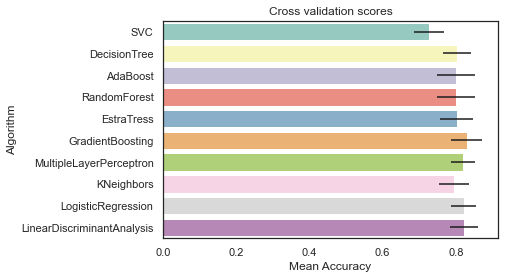

In [87]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv =kfold, n_jobs = 4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, "CrossValerrors": cv_std, "Algorithm":["SVC", 'DecisionTree', 'AdaBoost', 'RandomForest', 'EstraTress', "GradientBoosting", 'MultipleLayerPerceptron', 'KNeighbors', "LogisticRegression", 'LinearDiscriminantAnalysis']})

g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3", orient = 'h', **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title('Cross validation scores')

#### Hyperparameter tunning for best models

In [88]:
# 각 모델들의 메타 모델링
# adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion':['gini','entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm':['SAMME','SAMME.R'],
                 'n_estimators': [1,2],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:   14.2s finished


In [89]:
gsadaDTC.best_score_

0.8241317671092953

In [100]:
# extraTress
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
                "max_features": [1,3,10],
                'min_samples_split': [2,3,10],
                'min_samples_leaf': [1,3,10],
                'bootstrap': [False],
                'n_estimators': [100,300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.2min finished


0.8297242083758938

In [95]:
# RFC
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth': [None],
                'max_features': [1,3,10],
                'min_samples_split': [2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap': [False],
                'n_estimators': [100,300],
                'criterion': ['gini']}


gsRFC = GridSearchCV(RFC, param_grid= rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

0.8342951991828397

In [96]:
# gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100,200,300],
                'learning_rate': [0.1,0.05,0.01],
                'max_depth':[4,8],
                'min_samples_leaf': [100,150],
                'max_features': [0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   43.8s finished


0.8308861082737489

In [97]:
#SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   33.7s finished


0.8331332992849847

#### Plot learning curves

C:\Users\dldud\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


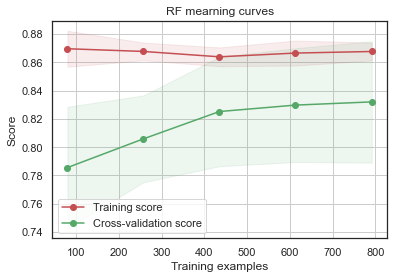

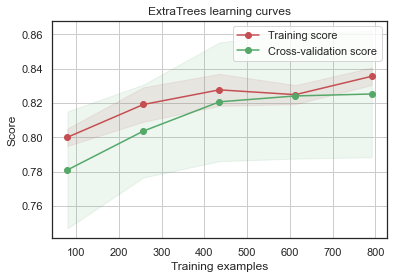

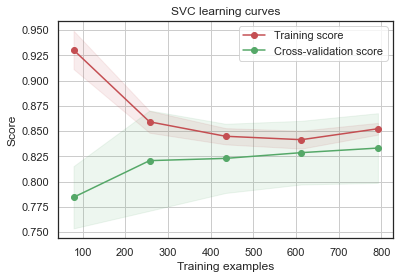

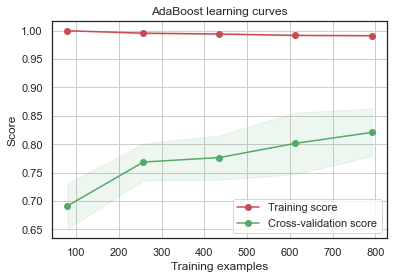

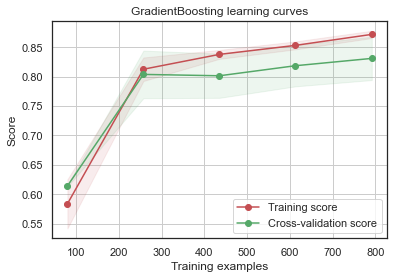

In [98]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim) #이게 무슨 뜻이지
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

> plt.fill_between(): 차트의 내부를 채운다
> 참고: https://financedata.github.io/posts/faq_matplotlib_fill_chart.html


그래디언트 부스팅과 에이타 부스트는 오버피팅

SVC와 extratrees는 예측을 더 잘 일반화

#### Features importance of tree based classifiers

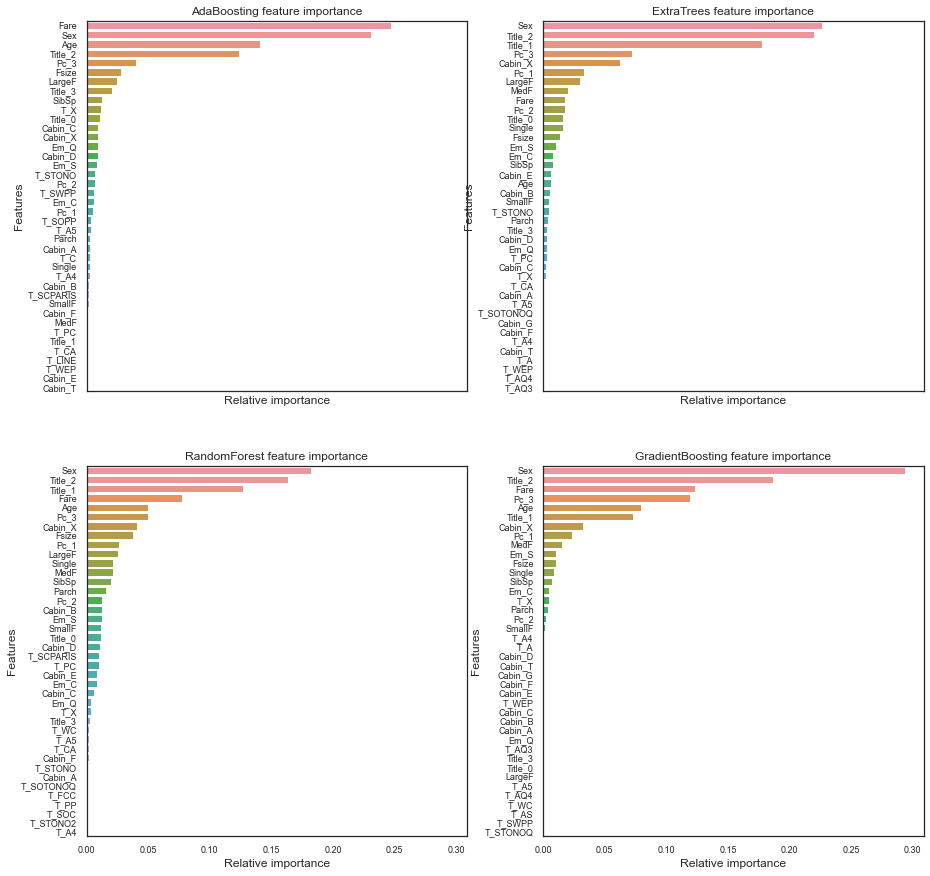

In [101]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex= "all", figsize = (15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the **Age, the Sex, the family size and the social standing** of the passengers more than the location in the boat.

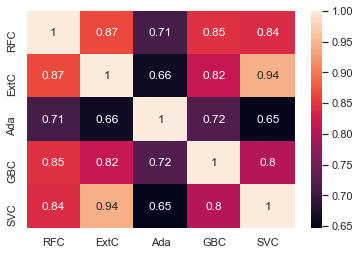

In [102]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### Ensemble modeling
#### Combining models


In [103]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting = 'soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

### Prediction
#### Predict and Submit results

In [104]:
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')

results = pd.concat([IDtest, test_Survived], axis = 1)

In [105]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
